# Coursera - Capstone Project for IBM Data Science Certificate
## By Meryem Tanarhte
# Description
This is the final assignment the Coursera Capstone Project:  
https://www.coursera.org/learn/applied-data-science-capstone/home/info
    
**Objective**: discover the best neighborhood in Frankfurt, Germany to open a Yoga studio

**Data Sources**: Excel file of a list of Frankfurt neighborhoods

**GitHub repository**:  
https://github.com/myt0170/Coursera_Capstone
    
# Table of Contents
- System and Data setup
- Part 1: Create initial table with all Frankfurt neighborhoods and their latitudes and longitudes using geocoder
- Part 2: Mapping Frankfurt neighborhoods using Folium 
- Part 3: Venue exploration and clustering using Foursquare
    
# System and Data setup 

In [1]:
import geocoder
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [2]:
# read Excel file with a list of  Frankfurt neighborhoods taken from from Wikipedia and adapted to Excel

df = pd.read_excel('frankfurt_districts.xls')

In [3]:
# Print the geographical coordinates of Frankfurt using geocoder
address = 'Frankfurt am Main, Germany'

geolocator = Nominatim(user_agent="geo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Frankfurt are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Frankfurt are 50.1106444, 8.6820917.


# Part 1: Create initial table with all Frankfurt neighborhoods and their latitudes and longitudes using geocoder

In [4]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Frankfurt, Germany'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [5]:
# Get the geographical coordinates of each neighborhood 
neighborhoods = df['Neighborhood']    
coords = [ get_latlng(neighborhood) for neighborhood in neighborhoods.tolist() ]

In [6]:
# initialize your variable to None
lat_lng_coords = None

#Create extra columns
df['Latitude'] = pd.Series("", index=df.index)
df['Longitude'] = pd.Series("", index=df.index)

df.columns

Index(['Borough', 'Neighborhood', 'Latitude', 'Longitude'], dtype='object')

In [7]:
# add the new columns to the existing dataframe
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [8]:
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Innenstadt I,Gallus,50.10610,8.64109
1,Innenstadt I,Gutleutviertel,50.10307,8.66243
2,Innenstadt I,Bahnhofsviertel,50.10778,8.66959
3,Innenstadt I,Altstadt,50.11138,8.68356
4,Innenstadt I,Innenstadt,50.11363,8.67069


# Part 2: Mapping Frankfurt neighborhoods using Folium

In [9]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{} - {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)

map_frankfurt  

# Part 3: Venue exploration and clustering using Foursquare

In [10]:
# function to repeat the exploring process to all the neighborhoods in Frankfurt
def getNearbyVenues(names, latitudes, longitudes, radius=2000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [11]:
# Define Foursquare Credentials and Version
CLIENT_ID = '3FRILL2TR3CK2R3ZI4SKGQX3DVCJXY52COPRP0CPX41JKC2B' # my Foursquare ID
CLIENT_SECRET = 'UBOP5QICUGWUTN33GJWVJ35Q3AXWM50GF0MBSYZODLXHJIPI' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3FRILL2TR3CK2R3ZI4SKGQX3DVCJXY52COPRP0CPX41JKC2B
CLIENT_SECRET:UBOP5QICUGWUTN33GJWVJ35Q3AXWM50GF0MBSYZODLXHJIPI


In [12]:
# Use category id 4bf58dd8d48988d102941735 to only get the yoga studios
ffm_venues_yoga = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d102941735')
ffm_venues_yoga.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gutleutviertel,50.10307,8.66243,Yoga Vidya,50.108663,8.660715,Athletics & Sports
1,Bahnhofsviertel,50.10778,8.66959,Yoga Vidya,50.108663,8.660715,Athletics & Sports
2,Bahnhofsviertel,50.10778,8.66959,Yoga Welt,50.114556,8.668547,Yoga Studio
3,Bahnhofsviertel,50.10778,8.66959,Dunkleys Massage,50.111240,8.676157,Yoga Studio
4,Bahnhofsviertel,50.10778,8.66959,Hot Yoga Frankfurt,50.113306,8.677450,Yoga Studio


In [13]:
ffm_venues_yoga.shape

(73, 7)

In [14]:
# function to add markers for given venues to map
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [15]:
map_ffm_yoga = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(ffm_venues_yoga, 'red', map_ffm_yoga)
map_ffm_yoga

# Venue Search

### Find the number of Yoga-friendly venues in each Neighborhood.
### Yoga-Friendly Venues are considered to be:
- Offices (Category Id: '4d4b7105d754a06375d81259')
- Universities (Category Id: '4bf58dd8d48988d1ae941735')
- Parks and Gardens (Category Id: '4bf58dd8d48988d163941735')

In [16]:
ffm_venues_office = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=1000, categoryIds='4d4b7105d754a06375d81259')
ffm_venues_office.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gallus,50.1061,8.64109,Packstation 152,50.105089,8.644101,Post Office
1,Gallus,50.1061,8.64109,DB Regio,50.106102,8.638988,Office
2,Gallus,50.1061,8.64109,DB Fernverkehr,50.106942,8.639374,Office
3,Gallus,50.1061,8.64109,"Gekko House, Frankfurt, a Tribute Portfolio Hotel",50.106086,8.652833,Hotel
4,Gallus,50.1061,8.64109,Hacienda Nápoles,50.107230,8.629185,Club House


In [17]:
ffm_venues_office.shape

(1598, 7)

In [18]:
ffm_venues_uni = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d1ae941735')
ffm_venues_uni.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gallus,50.106100,8.641090,European School Of Design,50.115066,8.643471,University
1,Gutleutviertel,50.103070,8.662430,"Haus 29 – Zentrum der Zahn-, Mund- und Kieferh...",50.094463,8.656876,Medical Center
2,"Bockenheim, Westend-Süd, Westend-Nord",50.116923,8.670733,Aussichtsplattform Uni Frankfurt,50.126964,8.668718,University
3,"Bockenheim, Westend-Süd, Westend-Nord",50.116923,8.670733,Johann Wolfgang Goethe-Universität,50.127292,8.667161,University
4,"Bockenheim, Westend-Süd, Westend-Nord",50.116923,8.670733,Campus Westend / IG-Farben-Haus,50.124873,8.670428,University


In [19]:
ffm_venues_uni.shape

(27, 7)

In [20]:
ffm_venues_parks = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d163941735')
ffm_venues_parks.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gallus,50.1061,8.64109,Lotte Specht Park,50.106952,8.634889,Park
1,Gallus,50.1061,8.64109,Skyline Garden,50.109063,8.652880,Park
2,Gallus,50.1061,8.64109,Sommerhoffpark,50.096242,8.642844,Park
3,Gallus,50.1061,8.64109,Licht- und Luftbad,50.093798,8.646702,Park
4,Gallus,50.1061,8.64109,Zeppelinpark,50.111593,8.631244,Park


In [22]:
ffm_venues_parks.shape

(268, 7)

#### Create empty columns for each Venue Type

In [23]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [24]:
df_data = df.copy()
df_data.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)
addColumn(df_data, 'Yoga', ffm_venues_yoga)
addColumn(df_data, 'Offices', ffm_venues_office)
addColumn(df_data, 'Universities', ffm_venues_uni)
addColumn(df_data, 'Parks', ffm_venues_parks)
df_data

,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
0,Innenstadt I,Gallus,50.106100,8.641090,0.0,50.0,1.0,11.0
1,Innenstadt I,Gutleutviertel,50.103070,8.662430,1.0,50.0,1.0,12.0
2,Innenstadt I,Bahnhofsviertel,50.107780,8.669590,7.0,50.0,0.0,23.0
3,Innenstadt I,Altstadt,50.111380,8.683560,8.0,50.0,0.0,31.0
4,Innenstadt I,Innenstadt,50.113630,8.670690,11.0,50.0,0.0,20.0
5,Innenstadt II,"Bockenheim, Westend-Süd, Westend-Nord",50.116923,8.670733,11.0,50.0,5.0,19.0
6,Innenstadt III,"Nordend-West, Nordend-Ost",50.128900,8.689968,5.0,40.0,2.0,12.0
7,Bornheim/Ostend,Ostend,50.116240,8.698190,4.0,48.0,1.0,14.0
8,Bornheim/Ostend,Bornheim,50.130500,8.711160,2.0,43.0,1.0,7.0
9,Süd,Flughafen,50.052210,8.574740,1.0,49.0,0.0,0.0


In [25]:
ffm_cluster = df_data.iloc[:,4:]
print(ffm_cluster.shape)
ffm_cluster.head()

(45, 4)


,Yoga,Offices,Universities,Parks
0,0.0,50.0,1.0,11.0
1,1.0,50.0,1.0,12.0
2,7.0,50.0,0.0,23.0
3,8.0,50.0,0.0,31.0
4,11.0,50.0,0.0,20.0


Check optimal # of clusters

In [26]:
elbow = []
for k in range(1,len(ffm_cluster)):
    km = KMeans(n_clusters = k, random_state = 0).fit(ffm_cluster)
    elbow.append(km.inertia_)  

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (42) found smaller than n_clusters (43). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (42) found smaller than n_clusters (44). Possibly due to duplicate points in X.
  return_n_iter=True)


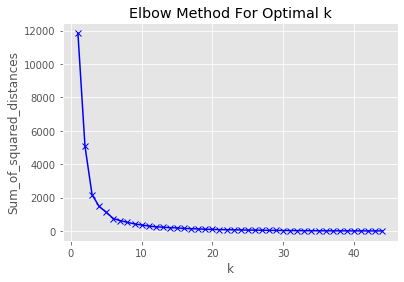

In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])
K = range(1,len(ffm_cluster))
#plt.figure(figsize =(20,10))
plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Impossible to see the elbow point. Although can see it occurs much closer to 0, so we will replot with just a subset of the data

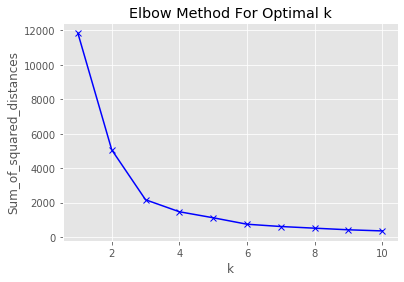

In [28]:
elbow2 = elbow[0:10]
K = range(1,11)
#plt.figure(figsize =(20,10))
plt.plot(K,  elbow2,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal k = 3 according to plot

### Clustering

In [30]:
cluster_num = 3
ffm_kmeans = KMeans(n_clusters = cluster_num, random_state = 0).fit(ffm_cluster)

In [31]:
df_data.insert(0,'Cluster_Labels', ffm_kmeans.labels_)
df_data.head()

,Cluster_Labels,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
0,2,Innenstadt I,Gallus,50.10610,8.64109,0.0,50.0,1.0,11.0
1,2,Innenstadt I,Gutleutviertel,50.10307,8.66243,1.0,50.0,1.0,12.0
2,2,Innenstadt I,Bahnhofsviertel,50.10778,8.66959,7.0,50.0,0.0,23.0
3,2,Innenstadt I,Altstadt,50.11138,8.68356,8.0,50.0,0.0,31.0
4,2,Innenstadt I,Innenstadt,50.11363,8.67069,11.0,50.0,0.0,20.0


In [32]:
df_data.tail()

,Cluster_Labels,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
40,1,Kalbach/Riedberg,Kalbach-Riedberg,50.17666,8.64212,0.0,41.0,4.0,4.0
41,0,Nieder-Erlenbach,Nieder-Erlenbach,50.20354,8.70874,0.0,13.0,0.0,0.0
42,0,Harheim,Harheim,50.18258,8.69291,0.0,2.0,0.0,0.0
43,0,Nieder-Eschbach,Nieder-Eschbach,50.19959,8.67364,0.0,13.0,0.0,0.0
44,0,Bergen-Enkheim,Bergen-Enkheim,50.15535,8.75416,0.0,25.0,0.0,1.0


### Visualize Clusters

In [33]:
# create map

cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(df_data['Latitude'], df_data['Longitude'], df_data['Neighborhood'], df_data['Cluster_Labels']):
    label = 'Cluster #: {} Neighborhood: {} '.format(cluster,poi)
    label = folium.Popup(label, parse_html = True)
    if cluster == 0:
        color="green" 
    elif cluster == 1:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(cluster_map)
cluster_map
       

## Results

Yoga-Friendly neighborhoods

In [34]:
Neighborhoods_Good = df_data[df_data['Cluster_Labels'] == 0]
Neighborhoods_Good

,Cluster_Labels,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
14,0,West,Schwanheim,50.08731,8.58145,0.0,18.0,0.0,2.0
16,0,West,Nied,50.10665,8.58209,0.0,21.0,1.0,1.0
20,0,West,Zeilsheim,50.09704,8.50020,0.0,5.0,0.0,0.0
21,0,West,Sindlingen,50.08232,8.51624,0.0,16.0,0.0,0.0
34,0,Nord-Ost,Berkersheim,50.17305,8.69782,0.0,1.0,0.0,0.0
35,0,Nord-Ost,Frankfurter Berg,50.16626,8.67134,1.0,21.0,0.0,0.0
41,0,Nieder-Erlenbach,Nieder-Erlenbach,50.20354,8.70874,0.0,13.0,0.0,0.0
42,0,Harheim,Harheim,50.18258,8.69291,0.0,2.0,0.0,0.0
43,0,Nieder-Eschbach,Nieder-Eschbach,50.19959,8.67364,0.0,13.0,0.0,0.0
44,0,Bergen-Enkheim,Bergen-Enkheim,50.15535,8.75416,0.0,25.0,0.0,1.0


Bad Neighborhoods for Yoga Studios

In [35]:
Neighborhoods_Bad = df_data[df_data['Cluster_Labels'] == 1]
Neighborhoods_Bad

,Cluster_Labels,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
6,1,Innenstadt III,"Nordend-West, Nordend-Ost",50.12890,8.689968,5.0,40.0,2.0,12.0
8,1,Bornheim/Ostend,Bornheim,50.13050,8.711160,2.0,43.0,1.0,7.0
9,1,Süd,Flughafen,50.05221,8.574740,1.0,49.0,0.0,0.0
12,1,Süd,Oberrad,50.10049,8.727280,0.0,42.0,0.0,0.0
13,1,Süd,Niederrad,50.08675,8.646050,0.0,46.0,1.0,3.0
15,1,West,Griesheim,50.10266,8.602740,1.0,38.0,0.0,1.0
17,1,West,Sossenheim,50.12193,8.568390,0.0,43.0,1.0,5.0
18,1,West,Höchst,50.09909,8.543880,0.0,44.0,1.0,4.0
19,1,West,Unterliederbach,50.11077,8.537960,0.0,40.0,1.0,2.0
22,1,Mitte-West,Rödelheim,50.12437,8.605990,0.0,41.0,1.0,5.0


Neighborhoods that are neither goodd or bad for Yoga studios

In [36]:
Neighborhoods_Caut = df_data[df_data['Cluster_Labels'] == 2]
Neighborhoods_Caut

,Cluster_Labels,Borough,Neighborhood,Latitude,Longitude,Yoga,Offices,Universities,Parks
0,2,Innenstadt I,Gallus,50.106100,8.641090,0.0,50.0,1.0,11.0
1,2,Innenstadt I,Gutleutviertel,50.103070,8.662430,1.0,50.0,1.0,12.0
2,2,Innenstadt I,Bahnhofsviertel,50.107780,8.669590,7.0,50.0,0.0,23.0
3,2,Innenstadt I,Altstadt,50.111380,8.683560,8.0,50.0,0.0,31.0
4,2,Innenstadt I,Innenstadt,50.113630,8.670690,11.0,50.0,0.0,20.0
5,2,Innenstadt II,"Bockenheim, Westend-Süd, Westend-Nord",50.116923,8.670733,11.0,50.0,5.0,19.0
7,2,Bornheim/Ostend,Ostend,50.116240,8.698190,4.0,48.0,1.0,14.0
10,2,Süd,Sachsenhausen-Süd,50.104490,8.689920,5.0,49.0,1.0,17.0
11,2,Süd,Sachsenhausen-Nord,50.104490,8.689920,5.0,49.0,1.0,17.0
25,2,Mitte-West,STB 343,50.112080,8.683410,9.0,50.0,0.0,29.0


In [37]:
print( '# of Yoga Friendly Neighborhoods: ' + str(len(Neighborhoods_Good)))
print( '# of Neighborhoods to Avoid: ' + str(len(Neighborhoods_Bad)))
print( '# of Neighborhoods to be Cautious of: ' + str(len(Neighborhoods_Caut)))

# of Yoga Friendly Neighborhoods: 10
# of Neighborhoods to Avoid: 25
# of Neighborhoods to be Cautious of: 10


([<matplotlib.axis.XTick at 0x1a24b89ed0>,
 <a list of 3 Text xticklabel objects>)

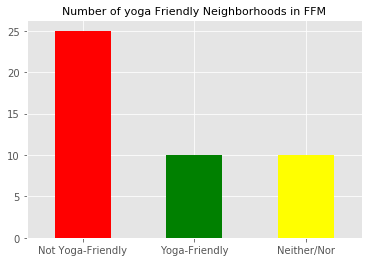

In [40]:
#Box plot of above data
df_data['Cluster_Labels'].value_counts().plot(kind = 'bar', color =['red', 'green', 'yellow'])
plt.title('Number of yoga Friendly Neighborhoods in FFM', fontsize = 11)
plt.xticks(np.arange(3), ('Not Yoga-Friendly', 'Yoga-Friendly', 'Neither/Nor'), rotation = 'horizontal')

Based on the results there appears to be plenty of 10 Yoga-Friendly neighborhoods to choose from in Frankfurt.
There also appears to be more than 25 neighborhoods that need to be avoided. With most of these being outside of the city center. The rest of neighborhoods (10) are neither good not bad for the yoga business. Additional market assessment is needed. 